# Assessing the Impact of Question Ambiguity in Question-Answering Systems

**Objective:** Evaluate how effectively LLMs detect and handle ambiguity in questions and analyze the impact on system performance and output uncertainty.

# STEP 2: DATASET ANALYSIS

- The process of manual annotation is discussed in thesis Chapter 3, Sections 3.2.2 - 3.2.3.
- The dataset analysis description can be found in Chapter 3, Section 3.3.

## Dataset Structure

After generation step, the dataset ['final_dataset_annotated_2.csv'](https://github.com/shmr-anna/assessing-the-impact-of-question-ambiguity-in-qa-systems/blob/main/data/final_dataset_annotated_2.csv) contains extra columns with generated ambiguous questions and answer type annotation. The total number of rows is 1265.

In [114]:
# Import libraries
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import re

In [138]:
# Load CSV file

df = pd.read_csv(
    'data/final_dataset_annotated_2.csv',
    sep=",", 
    engine="python"
)

df.head()

,title,context,target_word,question,annotated_question,answers,ambiguity_type,answer_annotation
0,Beyoncé,Beyoncé's first solo recording was a feature o...,album,"The album, Dangerously in Love achieved what s...",What spot did the album achieve?,"{'text': ['number four'], 'answer_start': [123]}",lexical,numeric
1,Beyoncé,Following the disbandment of Destiny's Child i...,album,"After her second solo album, what other entert...","After her second album, what other entertainme...","{'text': ['acting'], 'answer_start': [207]}",both,np
2,Beyoncé,Beyoncé's first solo recording was a feature o...,album,Beyonce's first album by herself was called what?,Her first album was called what?,"{'text': ['Dangerously in Love'], 'answer_star...",both,other entity
3,Beyoncé,Beyoncé's first solo recording was a feature o...,album,Beyonce's first solo album in the U.S. with wh...,Her first album in the U.S. featured which art...,"{'text': ['Jay Z'], 'answer_start': [48]}",both,person
4,Beyoncé,"In November 2003, she embarked on the Dangerou...",album,Destiny's Child's final album was named what?,Their final album was named what?,"{'text': ['Destiny Fulfilled'], 'answer_start'...",both,other entity


In [139]:
df.columns

Index(['title', 'context', 'target_word', 'question', 'annotated_question',
       'answers', 'ambiguity_type', 'answer_annotation'],
      dtype='object')

- *'title':* the name of the Wikipedia page
- *'context':* Wikipedia page context
- *'target_word':* ambiguous word 
- *'question':* original non-ambiguous question 
- *'annotated_question':* annotated ambiguous question 
- *'answers':* ground truth answer 
- *'ambiguity_type':* lexical, referential, both
- *'answer_annotation':* a set of first 418 ground truth answers annoteted

In [140]:
len(df)

1265

## Quantitative Dataset Analysis

- The code for quantitative analysis is adapted from (https://www.kaggle.com/code/yash9439/squad-dataset-analysis) and modified.

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>1. Dataset Stats</b> 
</div>

Sources for code:
- [df.nunique()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html)

In [141]:
# Compute total numbers 
print("Total number of questions:", len(df))
print("Number of unique titles:", df['title'].nunique())
print("Number of unique contexts:", df['context'].nunique())
print("Number of unique answers:", df['answers'].nunique())
print("Number of target words:", df['target_word'].nunique())
print("Number of ambiguous questions:", df['annotated_question'].notna().sum())
print("Number of original questions:", df['question'].notna().sum())

Total number of questions: 1265
Number of unique titles: 171
Number of unique contexts: 817
Number of unique answers: 1200
Number of target words: 64
Number of ambiguous questions: 1265
Number of original questions: 1265


In [142]:
# Compute lengths
df['context_len'] = df['context'].apply(lambda x: len(str(x).split()))
df['orig_len'] = df['question'].astype(str).apply(lambda x: len(x.split()))
df['ambig_len'] = df['annotated_question'].astype(str).apply(lambda x: len(x.split()))
df['answer_len'] = df['answers'].astype(str).apply(lambda x: len(x.split()))

# Print average number
print("Average Wikipedia context length:", round(df['context_len'].mean(), 2))
print("Average original question length:", round(df['orig_len'].mean(), 2))
print("Average ambiguous question length:", round(df['ambig_len'].mean(), 2))
print("Average ground truth answer length:", round(df['answer_len'].mean(), 2))


Average Wikipedia context length: 111.6
Average original question length: 11.63
Average ambiguous question length: 8.18
Average ground truth answer length: 5.48


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>2. Wikipedia Context and Title</b> 
</div>

In [143]:
# Compute average, min, max number
contexts_per_title = df.groupby('title')['context'].nunique()
print("Avg contexts per title:", round(contexts_per_title.mean(), 2))
print("Max contexts for a single title:", contexts_per_title.max())
print("Min contexts for a single title:", contexts_per_title.min())

Avg contexts per title: 4.78
Max contexts for a single title: 46
Min contexts for a single title: 1


In [144]:
# Count unique titles per target word
titles_per_word = df.groupby('target_word')['title'].nunique().sort_values(ascending=False)

# Print top 10
print("Top 10 target words by number of titles:\n", titles_per_word)

# Print overall average
print("\nAverage number of titles per target word:", round(titles_per_word.mean(), 2))


Top 10 target words by number of titles:
 target_word
track      17
table      16
cabinet    15
post       15
law        14
           ..
title       3
energy      2
album       1
company     1
work        1
Name: title, Length: 64, dtype: int64

Average number of titles per target word: 8.34


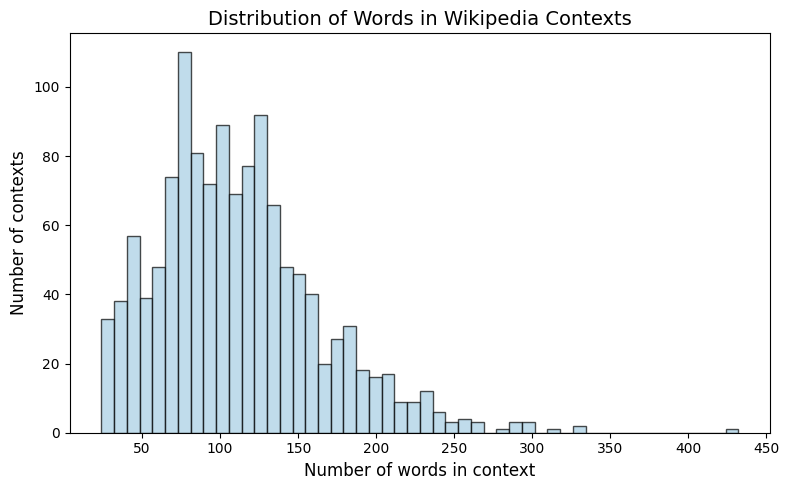

In [153]:
import matplotlib.pyplot as plt

# Compute context lengths
context_lengths = df['context'].apply(lambda x: len(str(x).split()))

# Create figure
fig, ax = plt.subplots(figsize=(8,5))

# Histogram
ax.hist(context_lengths, bins=50, color="#a6cee3", edgecolor="black", alpha=0.7)

# Labels and title
ax.set_title("Distribution of Words in Wikipedia Contexts", fontsize=14)
ax.set_xlabel("Number of words in context", fontsize=12)
ax.set_ylabel("Number of contexts", fontsize=12)

# Save 
plt.tight_layout()

fig.savefig("figures/words_in_context_length_2.png", dpi=300)


# Show
plt.show()


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>3. Target Word Distribution</b> 
</div>

In [154]:
# Target word count
word_counts = df['target_word'].value_counts()
print("Unique target words:", df['target_word'].nunique())


# Filter those with less than 20 occurrences
less_20_words = word_counts[word_counts < 20]

print("Target words with fewer than 20 sentences:")
less_20_words


Unique target words: 64
Target words with fewer than 20 sentences:


target_word
season    19
volume    19
bass      18
leg        9
Name: count, dtype: int64

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>4. Question Analysis</b> 
</div>

COUNT:
- average question length for orig vs. ambig question (barplot of the results)
- questioin length per target word for orig vs. ambig (barplot of the results)
- distribution of question types (barplot of the results)

In [155]:
# 1.Average question length for ambig and orig questions
orig_length = df['orig_len'] = df['question'].astype(str).apply(lambda x: len(x.split()))
ambig_length = df['ambig_len'] = df['annotated_question'].astype(str).apply(lambda x: len(x.split()))

print("Avg original len:", orig_length.mean())
print("Avg ambiguous len:", ambig_length.mean())

Avg original len: 11.627667984189724
Avg ambiguous len: 8.181818181818182


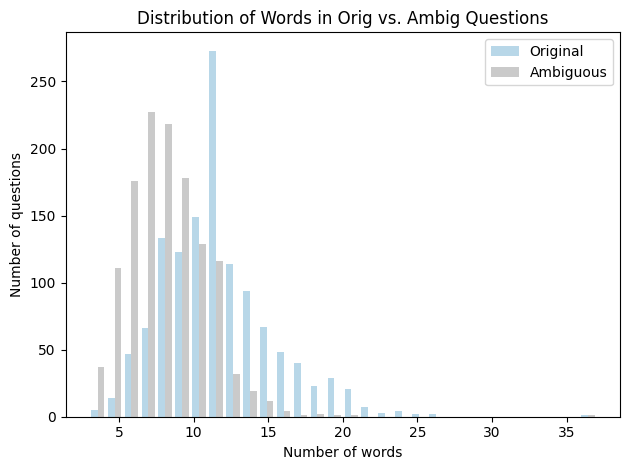

In [157]:
import matplotlib.pyplot as plt

# Plot
plt.hist([orig_length, ambig_length],
         bins=30,
         label=['Original', 'Ambiguous'],
         color=['#a6cee3','#bdbdbd'],  
         alpha=0.8)

plt.title("Distribution of Words in Orig vs. Ambig Questions")
plt.xlabel("Number of words")
plt.ylabel("Number of questions")
plt.legend()

plt.tight_layout()

plt.savefig("figures/question_length_2.png", dpi=300)

plt.show()

In [158]:
# 2. Question length per target word
# Add lengths per row
df["orig_len"]  = df["question"].apply(lambda x: len(str(x).split()))
df["ambig_len"] = df["annotated_question"].apply(lambda x: len(str(x).split()))

# Aggregate per target word
len_per_word = df.groupby("target_word").agg({
    "orig_len": "mean",
    "ambig_len": "mean"
}).reset_index()
len_per_word

,target_word,orig_len,ambig_len
0,album,9.800000,8.700000
1,area,11.350000,8.750000
2,article,11.600000,8.700000
3,ball,17.050000,11.450000
4,bank,12.600000,10.750000
...,...,...,...
59,title,10.850000,8.050000
60,track,10.600000,7.450000
61,volume,12.210526,8.315789
62,way,12.950000,8.350000


In [159]:
len_per_word.to_csv("len_per_word.csv", index=False)
len_per_word.columns

Index(['target_word', 'orig_len', 'ambig_len'], dtype='object')

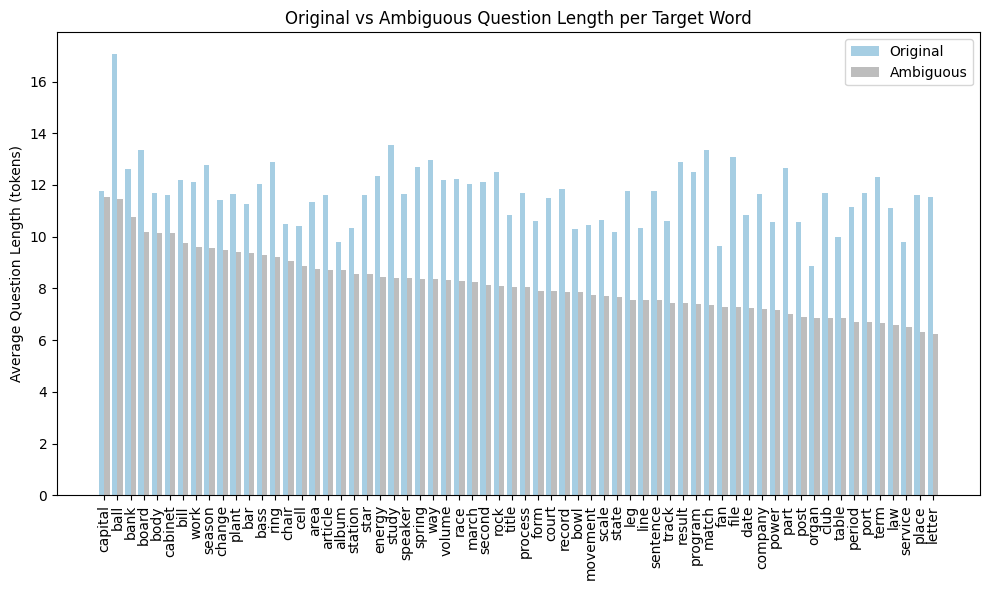

In [160]:
# Plot generated with the help of 'gpt-4o' model

# Sort by ambiguous length 
len_per_word_sorted = len_per_word.sort_values("ambig_len", ascending=False)

x = np.arange(len(len_per_word_sorted))
width = 0.4

plt.figure(figsize=(10,6))
plt.bar(x - width/2, len_per_word_sorted["orig_len"], width,
        label="Original", color="#a6cee3")
plt.bar(x + width/2, len_per_word_sorted["ambig_len"], width,
        label="Ambiguous", color="#bdbdbd")

plt.xticks(x, len_per_word_sorted["target_word"], rotation=90)
plt.ylabel("Average Question Length (tokens)")
plt.title("Original vs Ambiguous Question Length per Target Word")
plt.legend()
plt.tight_layout()
 
plt.savefig("figures/orig_ambig_qn_length_target_word_2.png", dpi=300)

plt.show()

In [161]:
# 3.Distribution of questioin types
def token_overlap(a, b):
    a_tokens, b_tokens = set(str(a).lower().split()), set(str(b).lower().split())
    if not a_tokens or not b_tokens: return 0
    return len(a_tokens & b_tokens) / len(a_tokens | b_tokens)
df['overlap'] = df.apply(lambda r: token_overlap(r['question'], r['annotated_question']), axis=1)

print("Avg overlap score:", df['overlap'].mean())


Avg overlap score: 0.4309719869960284


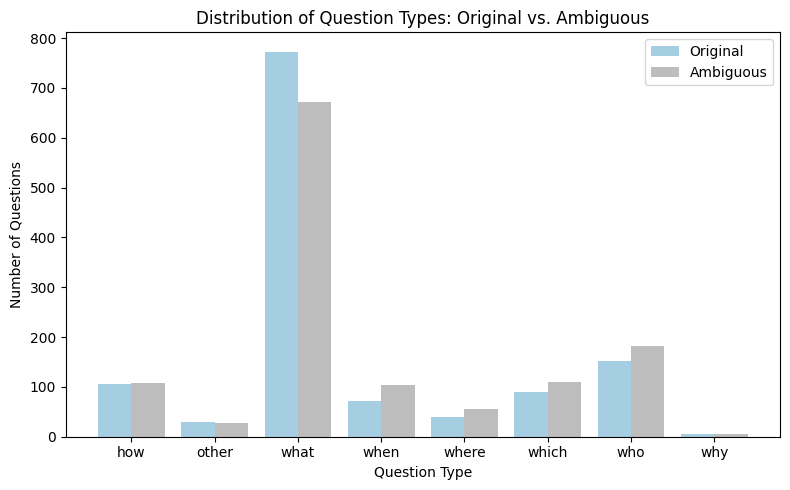

In [162]:
# Source for code: https://www.kaggle.com/code/yash9439/squad-dataset-analysis and 'gpt-4o'

# Plot the results
import matplotlib.pyplot as plt
import re

def categorize_question(q):
    if re.search(r'\bwhat\b', q, re.I): return "what"
    if re.search(r'\bwho\b', q, re.I): return "who"
    if re.search(r'\bwhen\b', q, re.I): return "when"
    if re.search(r'\bwhere\b', q, re.I): return "where"
    if re.search(r'\bwhy\b', q, re.I): return "why"
    if re.search(r'\bwhich\b', q, re.I): return "which"
    if re.search(r'\bhow\b', q, re.I): return "how"
    return "other"

# Categorize both original and ambiguous questions
df['orig_type'] = df['question'].astype(str).apply(categorize_question)
df['ambig_type'] = df['annotated_question'].astype(str).apply(categorize_question)

# Count frequencies
orig_counts = df['orig_type'].value_counts().sort_index()
ambig_counts = df['ambig_type'].value_counts().sort_index()

# Align indexes
all_types = sorted(set(orig_counts.index) | set(ambig_counts.index))
orig_counts = orig_counts.reindex(all_types, fill_value=0)
ambig_counts = ambig_counts.reindex(all_types, fill_value=0)

# Plot side-by-side bar chart
x = range(len(all_types))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(8,5))
ax.bar([p - bar_width/2 for p in x], orig_counts, width=bar_width, label="Original", color="#a6cee3")  # soft blue
ax.bar([p + bar_width/2 for p in x], ambig_counts, width=bar_width, label="Ambiguous", color="#bdbdbd")  # warm grey

ax.set_xticks(x)
ax.set_xticklabels(all_types)
ax.set_title("Distribution of Question Types: Original vs. Ambiguous")
ax.set_xlabel("Question Type")
ax.set_ylabel("Number of Questions")
ax.legend()

plt.tight_layout()

plt.savefig("figures/question_types_comparison_2.png", dpi=300)

plt.show()

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>5. Answer Analysis</b> 
</div>

In [169]:
# Count average answer length
answer_len = df['answer_len'] = df['answers'].astype(str).apply(lambda x: len(x.split()))
print("Avg answer length:", answer_len.mean())

Avg answer length: 5.483794466403162


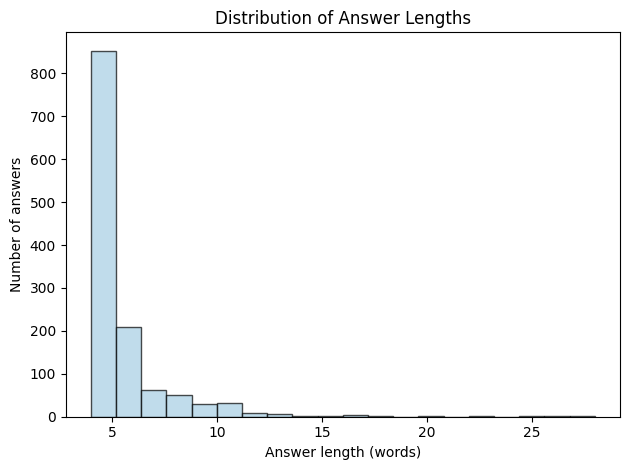

In [170]:
# Plot
plt.hist(df['answer_len'], bins=20, color="#a6cee3", edgecolor="black", alpha=0.7)
plt.title("Distribution of Answer Lengths")
plt.xlabel("Answer length (words)")
plt.ylabel("Number of answers")

plt.tight_layout()

plt.savefig("figures/answer_length_distribution_2.png", dpi=300)

plt.show()


In [171]:
# Based on manual annotation of 420 answers, count types of answers 
atype_counts = df['answer_annotation'].value_counts()
atype_counts

answer_annotation
np              80
other entity    76
date time       62
person          48
numeric         46
location        34
orgaization     30
other           29
ap               9
vp               3
pp               1
Name: count, dtype: int64

In [172]:
# Count percentage 
print((atype_counts/418*100).round(2))

answer_annotation
np              19.14
other entity    18.18
date time       14.83
person          11.48
numeric         11.00
location         8.13
orgaization      7.18
other            6.94
ap               2.15
vp               0.72
pp               0.24
Name: count, dtype: float64


## Ambiguity Type

In [173]:
# Count frequency of each ambiguity type
counts = df['ambiguity_type'].value_counts()

# Percentages
print((counts / len(df) * 100).round(2))

ambiguity_type
lexical        77.31
both           21.26
referential     1.42
Name: count, dtype: float64
